In [200]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt


def set_dark_mode():
    plt.style.use('dark_background')
    plt.rcParams['axes.facecolor'] = '#121212'
    plt.rcParams['figure.facecolor'] = '#121212'
    plt.rcParams['savefig.facecolor'] = '#121212'
    plt.rcParams['axes.edgecolor'] = 'white'
    plt.rcParams['axes.labelcolor'] = 'white'
    plt.rcParams['xtick.color'] = 'white'
    plt.rcParams['ytick.color'] = 'white'
    plt.rcParams['text.color'] = 'white'
    plt.rcParams['legend.edgecolor'] = 'white'
    plt.rcParams['lines.linewidth'] = 2.0

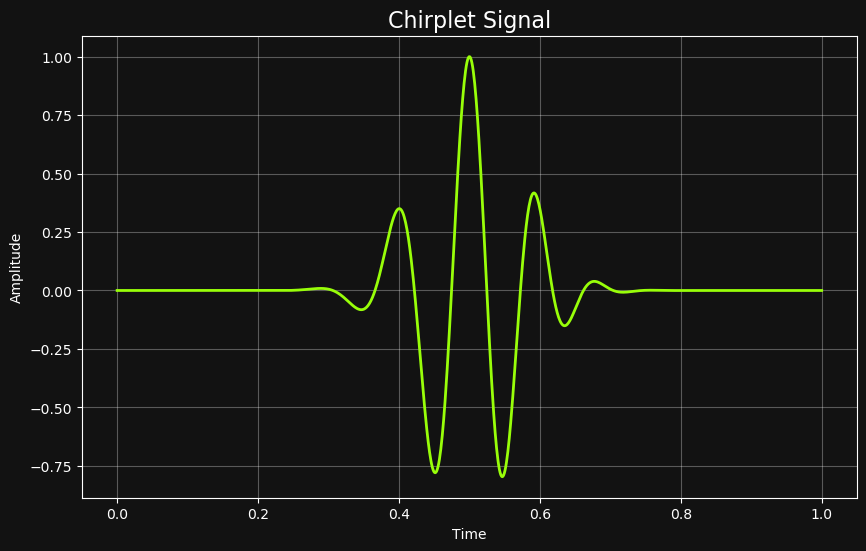

In [201]:
def chirplet(t, f0, f1, t0, sigma):
    """Generate a chirplet signal."""
    return np.exp(-((t - t0) / sigma) ** 2) * np.cos(2 * np.pi * (f0 * (t - t0) + f1 * (t - t0) ** 2))

# Generate simple chirplet
t = np.linspace(0, 1, 1000)
y = chirplet(t, f0=10, f1=5, t0=0.5, sigma=0.1)
set_dark_mode()
plt.figure(figsize=(10, 6))
plt.plot(t, y, color='#98FE09', linewidth=2)
plt.title('Chirplet Signal', fontsize=16)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)
plt.savefig('images/chirplet.svg')
plt.show()


In [ ]:
def chirplet(t, tau, fc, alpha1, alpha2=0.0, beta=1.0, phi=0.0):
    u = t - tau
    env = np.exp(-alpha1 * u**2)
    phase = 2*np.pi*(fc*u) + alpha2*u**2 + phi
    return beta * env * np.cos(phase)


def generate_mixed_dependency_timeseries(n_temperatures=100, temperature_range=(0, 1), 
                                        fs=1000, T=0.6, seed=42, change_probability=0.1):

    rng = np.random.default_rng(seed)
    
    # Generate time array
    t = np.arange(int(T * fs)) / fs
    k = len(t)  # number of time steps
    
    # Generate temperature values
    temperature_values = np.linspace(temperature_range[0], temperature_range[1], n_temperatures)
    
    # Initialize arrays
    timeseries_data = np.zeros((k, n_temperatures))
    dependency_types = np.zeros(k, dtype=int)  # 0=linear, 1=polynomial, 2=sinusoidal
    dependency_names = ['linear', 'polynomial', 'sinusoidal']
    
    # Generate column names
    column_names = [f"temp_{temp:.3f}" for temp in temperature_values]
    
    # Generate base signal for reference
    base_t, base_y, base_df = generate_random_signal()
    
    # Start with random dependency type
    current_dependency = rng.choice([0, 1, 2])
    dependency_types[0] = current_dependency
    
    
    # For each time step, create a mathematical relationship across temperatures
    for time_idx in range(k):
        base_value = base_y[time_idx]
        
        # Check if we should change dependency type
        if time_idx > 0 and rng.random() < change_probability:
            current_dependency = rng.choice([0, 1, 2])
            print(f"Time step {time_idx}: {dependency_names[current_dependency]}")
        
        dependency_types[time_idx] = current_dependency
        
        if current_dependency == 0:  # Linear
            # Linear dependency: signal = a * temp + b
            a = rng.uniform(-0.05, 0.05)  # Random slope between 0.01 and 0.05
            b = base_value  # intercept
            for temp_idx, temp in enumerate(temperature_values):
                timeseries_data[time_idx, temp_idx] = a * temp + b
                
        elif current_dependency == 1:  # Polynomial
            # Polynomial dependency: signal = a * temp^2 + b * temp + c
            # Random coefficients within reasonable ranges
            a = rng.uniform(-0.005, 0.02)  # Random quadratic coefficient
            b = rng.uniform(0.01, 0.03)   # Random linear coefficient
            c = base_value  # constant
            for temp_idx, temp in enumerate(temperature_values):
                timeseries_data[time_idx, temp_idx] = a * temp**2 + b * temp + c
                
        elif current_dependency == 2:  # Sinusoidal
            # Sinusoidal dependency: signal = amplitude * sin(freq * temp + phase) + offset
            amplitude = rng.uniform(-0.1, 0.1)  # Random amplitude
            freq = rng.uniform(1, 4) * np.pi  # Random frequency (1π to 4π)
            phase = rng.uniform(0, 2*np.pi)  # Random phase
            offset = base_value  # offset
            for temp_idx, temp in enumerate(temperature_values):
                timeseries_data[time_idx, temp_idx] = amplitude * np.sin(freq * temp + phase) + offset
    
    # Add small amount of noise for realism
    noise_std = 0.0002  # Small but noticeable noise
    for time_idx in range(k):
        noise = rng.normal(0, noise_std, n_temperatures)
        timeseries_data[time_idx, :] += noise
    
    return t, timeseries_data, temperature_values, column_names, dependency_types




def generate_random_signal():
    rng = np.random.default_rng()
    fs, T = 1000, 0.6
    t = np.arange(int(T * fs)) / fs
    y = np.zeros_like(t)

    # small global jitter
    s = 1.0 + rng.normal(0, 0.0005)          # ~0.05% time stretch
    amp_scale = np.exp(rng.normal(0, 0.01))  # ~1% amplitude drift
    tt = t * s

    # primary burst
    y += chirplet(tt, tau=0.08, fc=120, alpha1=900, beta=1.0)

    # echoes (very small variation)
    echo_times = np.array([0.12, 0.16, 0.20, 0.26, 0.33, 0.41, 0.50])
    echo_gains = np.exp(-4.0*(echo_times-0.10)) * 0.6
    for tau0, g0 in zip(echo_times, echo_gains):
        tau   = tau0 + rng.normal(0, 4e-5)     # ~0.2 ms jitter
        fc    = 120 + rng.normal(0, 0.1)       # small freq jitter
        phi   = rng.uniform(-0.1, 0.1)         # small phase shift
        y += chirplet(tt, tau=tau, fc=fc, alpha1=800, beta=g0, phi=phi)

    # scattering coda (tiny jitter, smooth decay)
    for tau0 in np.linspace(0.22, 0.58, 100):
        tau = tau0 + rng.normal(0, 4e-5)
        fc    = 120 + rng.normal(0, 0.1)       # small freq jitter
        g   = 0.5 * np.exp(-6*(tau0-0.20))
        y  += chirplet(tt, tau=tau, fc=fc, alpha1=1200, beta=g)

    y *= amp_scale

    idx = pd.date_range(start="2025-01-01", periods=len(t), freq=f"{1000/fs}ms")
    df = pd.DataFrame({"unique_id": "sensor_A", "ds": idx, "y": y})
    return t, y, df


In [203]:
def plot_single_temperature(timeseries_data, temperature_values, seed=42):
    """Plot a single random temperature time series."""
    np.random.seed(seed)
    temp_idx = np.random.choice(len(temperature_values))
    
    plt.figure(figsize=(10, 6))
    plt.plot(timeseries_data[:, temp_idx], color='#98FE09', linewidth=2)
    plt.title(f'Temperature {temperature_values[temp_idx]:.3f}', fontsize=16)
    plt.xlabel('Time Steps')
    plt.ylabel('Signal Value')
    plt.grid(True, alpha=0.3)
    plt.show()

# Plot single random temperature


In [206]:
def plot_random_temperatures(timeseries_data, temperature_values, n_temps=6, seed=42):
    """Plot n random temperature time series."""
    np.random.seed(seed)
    temp_indices = np.random.choice(len(temperature_values), n_temps, replace=False)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    colors = ['#02FEFA']*6
    
    for i, temp_idx in enumerate(temp_indices):
        ax = axes[i]
        ax.plot(timeseries_data[:, temp_idx], color=colors[i], linewidth=2)
        ax.set_title(f'Temperature = {temperature_values[temp_idx]:.3f}', fontsize=14)
        ax.set_xlabel('Time Steps', fontsize=15)
        ax.set_ylabel('Signal Value', fontsize=15)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('images/random_temperatures.svg')
    plt.show()

# Plot three random temperatures


Time step 2: sinusoidal
Time step 18: polynomial
Time step 23: polynomial
Time step 31: polynomial
Time step 36: sinusoidal
Time step 56: linear
Time step 88: linear
Time step 99: polynomial
Time step 118: sinusoidal
Time step 136: linear
Time step 139: linear
Time step 142: polynomial
Time step 147: linear
Time step 149: sinusoidal
Time step 172: linear
Time step 182: sinusoidal
Time step 198: polynomial
Time step 214: polynomial
Time step 241: linear
Time step 247: linear
Time step 256: sinusoidal
Time step 264: linear
Time step 271: polynomial
Time step 320: sinusoidal
Time step 323: polynomial
Time step 329: sinusoidal
Time step 353: polynomial
Time step 367: linear
Time step 368: polynomial
Time step 371: polynomial
Time step 375: polynomial
Time step 401: linear
Time step 427: polynomial
Time step 430: polynomial
Time step 452: sinusoidal
Time step 453: linear
Time step 469: sinusoidal
Time step 485: sinusoidal
Time step 504: sinusoidal
Time step 510: polynomial
Time step 518: si

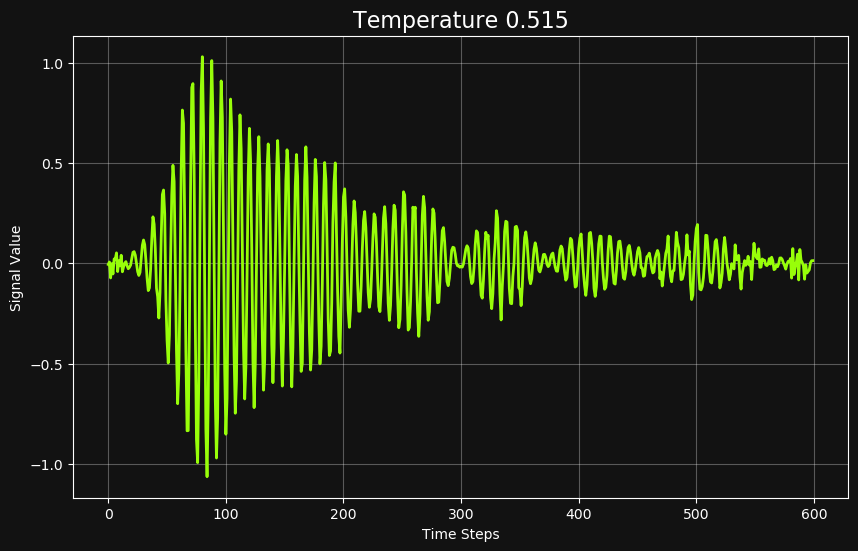

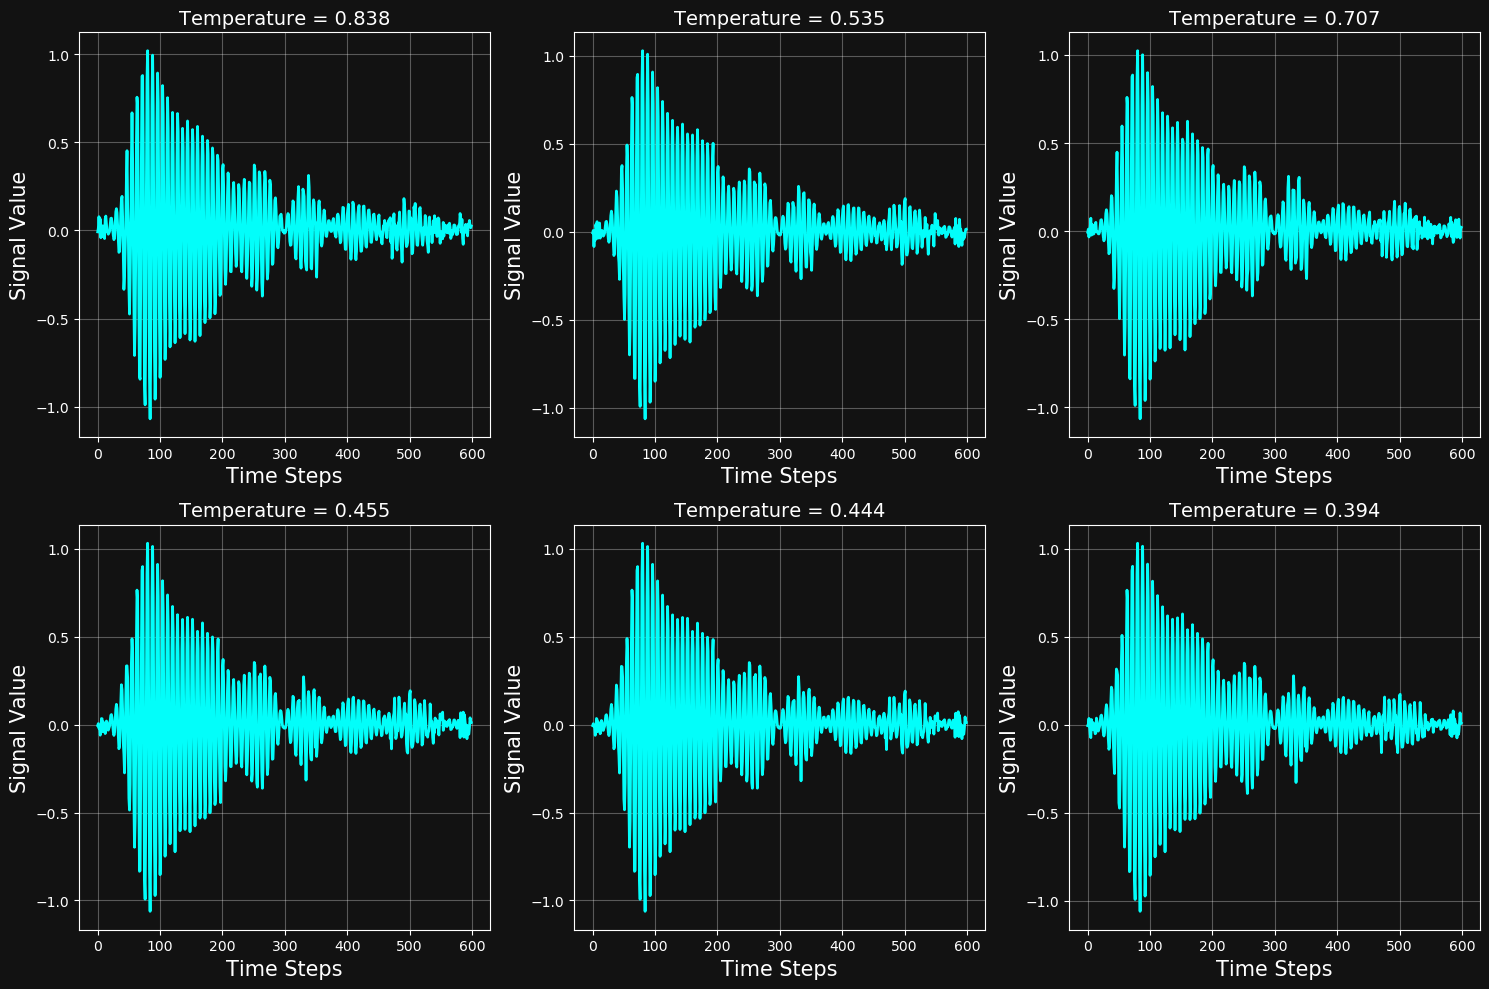

In [207]:

t_mixed, timeseries_mixed, temperature_values, column_names, dependency_types = generate_mixed_dependency_timeseries(
    n_temperatures=100, 
    temperature_range=(0, 1), 
    fs=1000,
    T=0.6,
    seed=42,
    change_probability=0.1  # 10% chance of changing dependency type at each time step
)

# Create DataFrame
df_mixed = pd.DataFrame(timeseries_mixed, columns=column_names)
df_mixed.index = t_mixed

set_dark_mode()
plot_single_temperature(timeseries_mixed, temperature_values)
plot_random_temperatures(timeseries_mixed, temperature_values, n_temps=6)




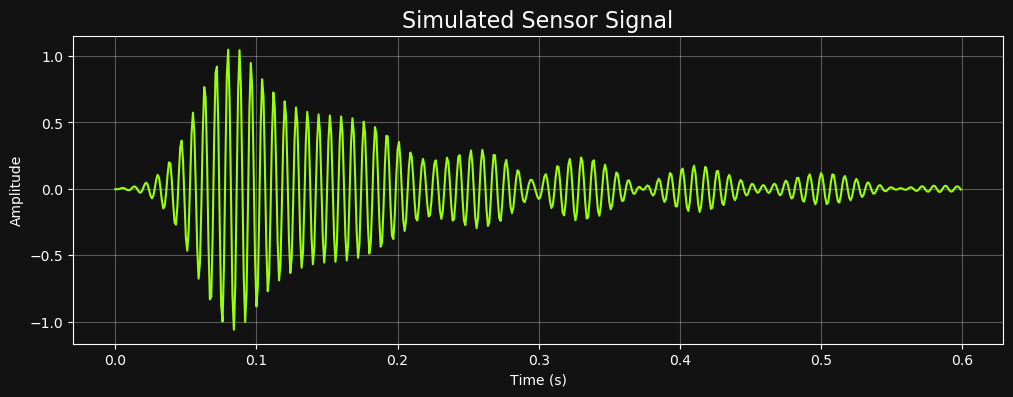

In [205]:
# Generate and plot a random signal
t, y, df = generate_random_signal()

plt.figure(figsize=(12, 4))
plt.plot(t, y, color='#98FE09', linewidth=1.5)
plt.title('Simulated Sensor Signal', fontsize=16)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)
plt.savefig('images/random_signal.svg')
plt.show()

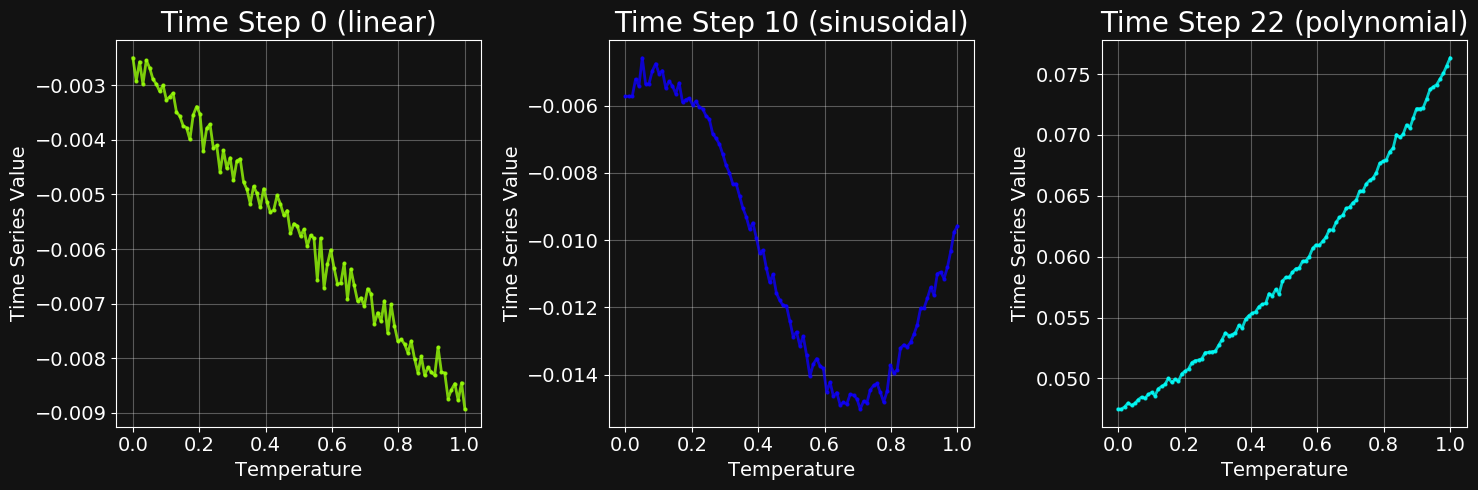

In [211]:

# Plot specific time steps to show different dependency types
time_steps_to_show = [0, 10, 22]
dependency_names = ['linear', 'polynomial', 'sinusoidal']
# Using only the specified colors
dep_colors = {'linear': '#98FE09', 'polynomial': '#02FEFA', 'sinusoidal': '#0E00F8'}
set_dark_mode()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()
for i, time_step in enumerate(time_steps_to_show):
    ax = axes[i]
    dep_type = dependency_types[time_step]
    dep_name = dependency_names[dep_type]
    color = dep_colors[dep_name]
    
    ax.plot(temperature_values, timeseries_mixed[time_step, :], 'o-', 
           markersize=2, color=color, alpha=0.8)
    ax.set_xlabel('Temperature', fontsize=12)
    ax.tick_params(axis='x', labelsize=14)  
    ax.tick_params(axis='y', labelsize=14)  
    ax.set_xlabel('Temperature', fontsize=14)  
    ax.set_ylabel('Time Series Value', fontsize=14)  

    ax.set_title(f'Time Step {time_step} ({dep_name})', fontsize=20)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/dependency_types.svg')
plt.show()


Time step 2: sinusoidal
Time step 18: polynomial
Time step 23: polynomial
Time step 31: polynomial
Time step 36: sinusoidal
Time step 56: linear
Time step 88: linear
Time step 99: polynomial
Time step 118: sinusoidal
Time step 136: linear
Time step 139: linear
Time step 142: polynomial
Time step 147: linear
Time step 149: sinusoidal
Time step 172: linear
Time step 182: sinusoidal
Time step 198: polynomial
Time step 214: polynomial
Time step 241: linear
Time step 247: linear
Time step 256: sinusoidal
Time step 264: linear
Time step 271: polynomial
Time step 320: sinusoidal
Time step 323: polynomial
Time step 329: sinusoidal
Time step 353: polynomial
Time step 367: linear
Time step 368: polynomial
Time step 371: polynomial
Time step 375: polynomial
Time step 401: linear
Time step 427: polynomial
Time step 430: polynomial
Time step 452: sinusoidal
Time step 453: linear
Time step 469: sinusoidal
Time step 485: sinusoidal
Time step 504: sinusoidal
Time step 510: polynomial
Time step 518: si

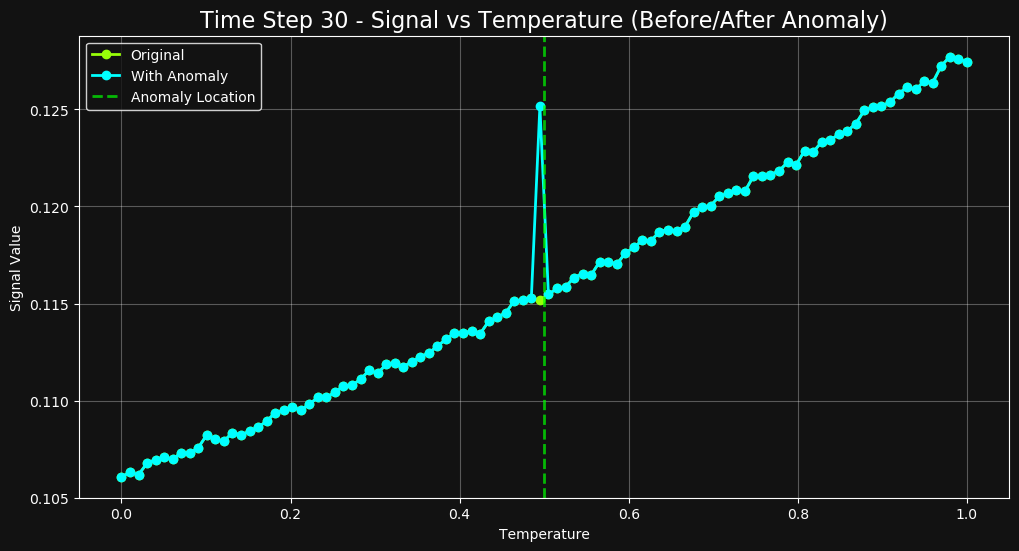

In [222]:
def add_anomaly(timeseries_data, time_step, temperature_value, spike_magnitude=0.1, temperature_values=None):
    """
    Add a spike anomaly at a specific time step and temperature.
    
    Parameters:
    -----------
    timeseries_data : numpy.ndarray
        Time series data (k x n)
    time_step : int
        Time step where to add the anomaly
    temperature_value : float
        Temperature value where to add the anomaly
    spike_magnitude : float
        Magnitude of the spike anomaly
    temperature_values : numpy.ndarray
        Array of temperature values to find closest match
    
    Returns:
    --------
    numpy.ndarray : Modified time series data with anomaly
    """
    data = timeseries_data.copy()
    
    if temperature_values is not None:
        # Find closest temperature index
        temp_idx = np.argmin(np.abs(temperature_values - temperature_value))
        actual_temp = temperature_values[temp_idx]
    else:
        # Assume temperature_value is already an index
        temp_idx = int(temperature_value * len(timeseries_data[0]))
        actual_temp = temperature_value
    
    # Add spike anomaly
    data[time_step, temp_idx] += spike_magnitude
    
    print(f"Added spike anomaly:")
    print(f"  Time step: {time_step}")
    print(f"  Temperature: {actual_temp:.3f} (index {temp_idx})")
    print(f"  Spike magnitude: {spike_magnitude}")
    
    return data


t_mixed, timeseries_mixed, temperature_values, column_names, dependency_types = generate_mixed_dependency_timeseries(
    n_temperatures=100, 
    temperature_range=(0, 1), 
    fs=1000,
    T=0.6,
    seed=42,
    change_probability=0.1  # 10% chance of changing dependency type at each time step
)



# Example: Add anomaly at time step 30, temperature 0.5
timeseries_with_anomaly = add_anomaly(
    timeseries_mixed, 
    time_step=30, 
    temperature_value=0.5, 
    spike_magnitude=0.01,
    temperature_values=temperature_values
)

# Plot the anomaly
# Corrected plotting - shows fixed time step across temperatures
plt.figure(figsize=(12, 6))
time_step = 30
plt.plot(temperature_values, timeseries_mixed[time_step, :], 'o-', color='#98FE09', linewidth=2, label='Original')
plt.plot(temperature_values, timeseries_with_anomaly[time_step, :], 'o-', color='cyan', linewidth=2, label='With Anomaly')
plt.axvline(x=0.5, color='lime', linestyle='--', alpha=0.7, label='Anomaly Location')
plt.title(f'Time Step {time_step} - Signal vs Temperature (Before/After Anomaly)', fontsize=16)
plt.xlabel('Temperature')
plt.ylabel('Signal Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('images/anomaly_detection_input.svg')
plt.show()

In [ ]:



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, Optional

from statsforecast import StatsForecast
from statsforecast.models import AutoETS   # simple, fast probabilistic model
# You could use AutoARIMA/MSTL/etc. too.

def detect_anomalies(
    timeseries_data: np.ndarray,
    temperature_values: pd.DatetimeIndex, timegpt_level: float = 0.90
) -> pd.DataFrame:
    y = np.asarray(timeseries_data, dtype=float)
    n = len(y)
    if len(temperature_values) != n:
        raise ValueError("temperature_values length must match timeseries_data length.")

    # Build long-format df expected by StatsForecast
    start = pd.Timestamp("2024-01-01")
    ds = pd.date_range(start, periods=n, freq="D")
    df = pd.DataFrame({"unique_id": 0, "ds": ds, "y": y})

    # Model & forecaster
    # AutoETS provides probabilistic insample/fitted intervals easily.
    levels = [int(round(timegpt_level * 100))]  # e.g., 90 -> 90% PI
    sf = StatsForecast(models=[AutoETS(season_length=1)], freq="D", n_jobs=-1)

    # Fit & get forecasts with fitted=True so we can retrieve INSAMPLE intervals
    _ = sf.forecast(df=df, h=1, level=levels, fitted=True)

    # Retrieve insample fitted values & intervals
    insample = sf.forecast_fitted_values()  # columns: unique_id, ds, y, <model>, <model>-lo-XX, <model>-hi-XX
    model_name = [c for c in insample.columns if c not in ("unique_id", "ds", "y") and "-lo-" not in c and "-hi-" not in c][0]
    lo_col = f"{model_name}-lo-{levels[0]}"
    hi_col = f"{model_name}-hi-{levels[0]}"

    # Flag anomalies: outside the interval
    is_anom = ~insample["y"].between(insample[lo_col], insample[hi_col])
    is_anom = is_anom.astype(int).to_numpy()

    # Assemble output to match your structure
    out = pd.DataFrame({
        "ds": insample["ds"].values,
        "y": insample["y"].values,
        "unique_id": 0,
        "is_anomaly": is_anom,
        "temperature_values": temperature_values,
    })
    # Optional: stash columns for plotting convenience
    out["_fitted_mean"] = insample[model_name].values
    out["_lo"] = insample[lo_col].values
    out["_hi"] = insample[hi_col].values
    out.attrs["model_name"] = model_name
    out.attrs["level"] = levels[0]
    return out



df_out = detect_anomalies( timeseries_data=timeseries_with_anomaly[time_step,:], temperature_values=temperature_values)



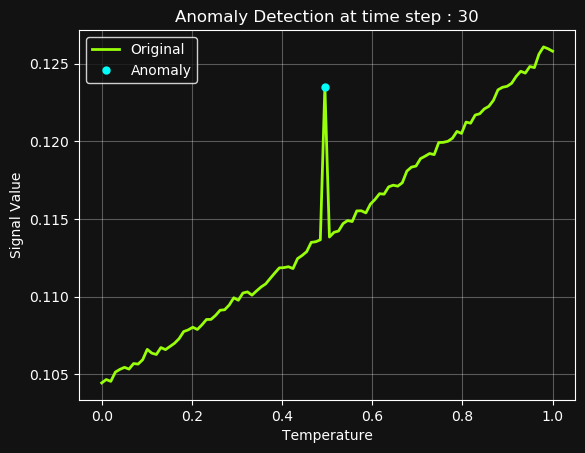

In [223]:
plt.plot(df_out['temperature_values'].values,df_out['y'].values, color='#98FE09', linewidth=2, label='Original')
plt.plot(df_out[df_out['is_anomaly']==1]['temperature_values'].values,df_out[df_out['is_anomaly']==1]['y'].values, '.', color='#02FEFA', linewidth=5, label='Anomaly', markersize=10)
plt.xlabel('Temperature')
plt.ylabel('Signal Value')
plt.title(f'Anomaly Detection at time step : {time_step}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('images/anomaly_detection.svg')
plt.show()


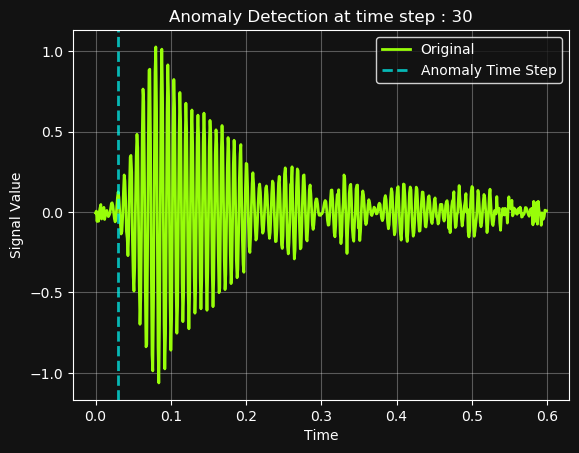

In [197]:

temperature_idx = np.argmin(np.abs(temperature_values-0.5))
plt.plot(t_mixed, timeseries_with_anomaly[:,temperature_idx], color='#98FE09', linewidth=2, label='Original')
plt.axvline(x=t_mixed[30], color='#02FEFA', linestyle='--', alpha=0.7, label='Anomaly Time Step')
plt.xlabel('Time')
plt.ylabel('Signal Value')
plt.title(f'Anomaly Detection at time step : {time_step}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
